In [1]:
import numpy as np
from tensorflow.keras.utils import to_categorical

In [4]:
actions = [
    'zero',
    'one',
    'two',
    'three',
    'four',
    'five'
]

In [5]:
# numpy 배열 합치기
data = np.concatenate([
    np.load('dataset/seq_zero_1660296101.npy'),
    np.load('dataset/seq_one_1660296101.npy'),
    np.load('dataset/seq_two_1660296101.npy'),
    np.load('dataset/seq_three_1660296101.npy'),
    np.load('dataset/seq_four_1660296101.npy'),
    np.load('dataset/seq_five_1660296101.npy')
], axis = 0)

In [6]:
data.shape

(5145, 30, 100)

In [7]:
# data의 마지막 값이 라벨이므로 x_data와 labels로 나누기
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

In [8]:
print(x_data.shape)
print(labels.shape)

(5145, 30, 99)
(5145,)


In [9]:
# One-hot encoding 진행
y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(5145, 6)

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

In [12]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(4630, 30, 99) (4630, 6)
(515, 30, 99) (515, 6)


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [14]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]), # input_shape = [30, 99], 30->윈도우의 크기, 99->랜드마크, visibility, 각도
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

In [15]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41984     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                                                 
Total params: 44,262
Trainable params: 44,262
Non-trainable params: 0
_________________________________________________________________


In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [17]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/200
143/145 [============================>.] - ETA: 0s - loss: 44.2676 - acc: 0.5162
Epoch 1: val_acc improved from -inf to 0.60000, saving model to models\model.h5
145/145 [==============================] - 3s 12ms/step - loss: 43.9470 - acc: 0.5171 - val_loss: 21.3827 - val_acc: 0.6000 - lr: 0.0010
Epoch 2/200
142/145 [============================>.] - ETA: 0s - loss: 7.2883 - acc: 0.7953
Epoch 2: val_acc improved from 0.60000 to 0.70291, saving model to models\model.h5
145/145 [==============================] - 2s 13ms/step - loss: 7.2527 - acc: 0.7948 - val_loss: 6.5958 - val_acc: 0.7029 - lr: 0.0010
Epoch 3/200
144/145 [============================>.] - ETA: 0s - loss: 4.1551 - acc: 0.8220
Epoch 3: val_acc improved from 0.70291 to 0.87573, saving model to models\model.h5
145/145 [==============================] - 2s 11ms/step - loss: 4.1366 - acc: 0.8225 - val_loss: 2.4770 - val_acc: 0.8757 - lr: 0.0010
Epoch 4/200
145/145 [==============================] - ETA: 0s - loss:

In [19]:
import matplotlib.pyplot as plt

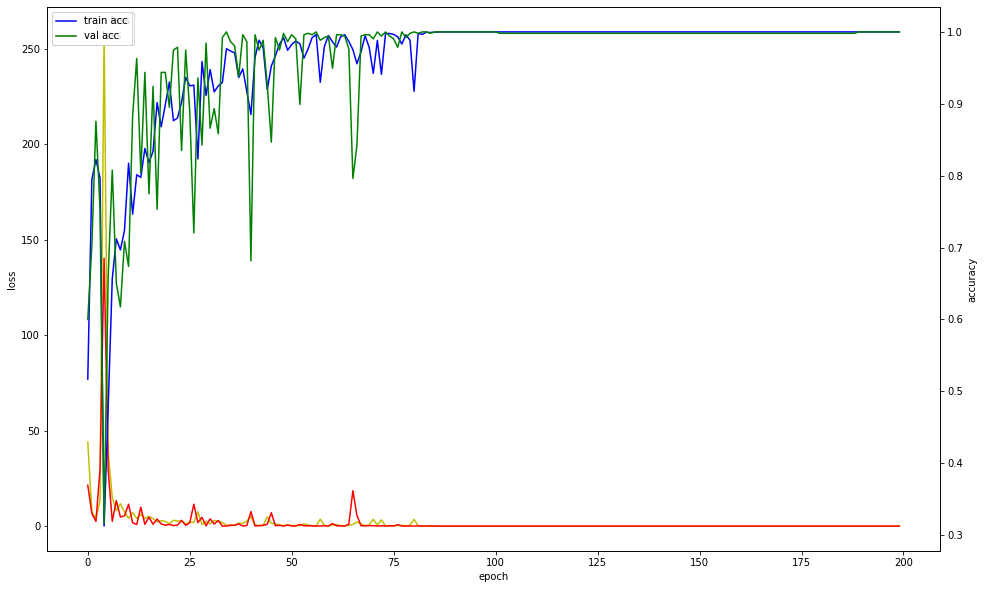

In [20]:
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()


In [21]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

In [22]:
model = load_model('models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

17/17 [==============================] - 0s 6ms/step


array([[[426,   0],
        [  0,  89]],

       [[433,   0],
        [  0,  82]],

       [[434,   0],
        [  0,  81]],

       [[418,   0],
        [  0,  97]],

       [[441,   0],
        [  0,  74]],

       [[423,   0],
        [  0,  92]]], dtype=int64)